<a href="https://colab.research.google.com/github/VishakBharadwaj94/amazon_from_space/blob/master/amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/
! kaggle datasets download nikitarom/planets-dataset -p /content/amazon

100% 1.50G/1.50G [00:15<00:00, 95.6MB/s]



In [2]:
!unzip -q /content/amazon/planets-dataset.zip -d /content/amazon

Streaming output truncated to the last 5000 lines.
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: /content/amazon/test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: /con

In [1]:
import pandas as pd

df = pd.read_csv('/content/amazon/planet/planet/train_classes.csv',low_memory=False)

In [2]:
df.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [3]:
len(df)

40479

In [4]:
df['tags'] = df.tags.str.split(" ")
df.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_right = pd.DataFrame(mlb.fit_transform(df['tags']),columns=mlb.classes_)
df_right.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [6]:
df.drop('tags',axis=1,inplace=True)
df.head()

,image_name
0,train_0
1,train_1
2,train_2
3,train_3
4,train_4


In [7]:
full_df = pd.concat([df,df_right],axis=1)
full_df.head()

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [8]:
from PIL import Image
from pathlib import Path
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import numpy as np

path = Path('/content/amazon/planet/planet')
def show_image(n):
  image_name = df.iloc[n,0]
  train_path = path/'train-jpg'
  image_path = train_path/f'{image_name}.jpg'
  im = Image.open(image_path)  
  print(df.iloc[n,1])
  imshow(im)

In [52]:
len(df),len(df_right)

(40479, 40479)

agriculture clear primary water


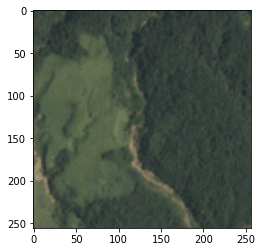

In [20]:
show_image(1)

clear primary


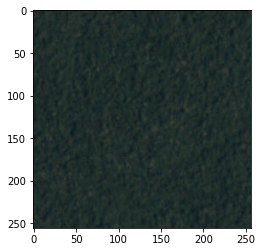

In [21]:
show_image(15)

agriculture clear cultivation primary


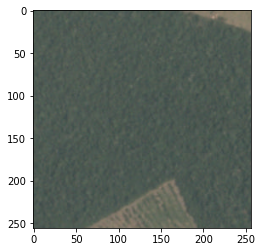

In [24]:
show_image(992)

In [9]:
class AmazonDataset:
    """Face Landmarks dataset."""

    def __init__(self, df, root_dir, transforms=None):
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms
    def __len__(self):
        return len(self.df)

    def __getitem__(self,n):
        image_name = self.root_dir/f'{self.df.iloc[n,0]}.jpg'   
        image = mpimg.imread(image_name).astype('float')      
        labels = self.df.iloc[n,1:].values.astype('float')  
        output = (image,labels)

        if self.transforms:
            for transform in self.transforms:
              output = transform(output)

        return output

In [10]:
msk = np.random.rand(len(full_df)) < 0.8
train_csv = full_df[msk]
valid_csv = full_df[~msk]

In [11]:
import torch 
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, example):
        image,labels = example[0],example[1]
        image = image.transpose(2,0,1)
        
        return (torch.from_numpy(image).float(),torch.from_numpy(labels).float())

In [12]:
train_ds = AmazonDataset(train_csv,path/'train-jpg',transforms=[ToTensor()])
valid_ds = AmazonDataset(valid_csv,path/'train-jpg',transforms=[ToTensor()])

In [13]:
from torch.utils.data import DataLoader 

train_dl = DataLoader(train_ds,16)
valid_dl = DataLoader(valid_ds,16)

In [14]:
x = next(iter(train_dl))

In [15]:
import torchvision

model = torchvision.models.resnet50(pretrained=True)

In [16]:
from torch import nn 

model.conv1 =  nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [17]:
model.fc = nn.Linear(in_features=2048, out_features=17, bias=True)

In [18]:
model.cuda()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
model(x[0].cuda()).shape

torch.Size([16, 17])

In [20]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [47]:
from fastprogress.fastprogress import progress_bar

class Learner:

    def __init__(self, model, dls, loss_func, lr, cbs, opt_func):
        self.model = model
        self.dls = dls
        self.loss_func = loss_func
        self.lr = lr
        self.opt_func=opt_func
        self.preds = None
        self.cbs = cbs
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')

    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

In [50]:
stats = [x[0].mean((0,1,2)),x[0].std((0,1,2))]

In [54]:
x[0].mean()

tensor(130.5262)

In [48]:
from torch.optim import Adam 
from torch.nn import BCEWithLogitsLoss

learn = Learner(model,dls,BCEWithLogitsLoss(),0.1,[SetupLearnerCB(),TrackResults()],Adam)

In [49]:
learn.fit(1)

In [33]:
from fastbook import *
class Callback(GetAttr): 
  _default='learner'

In [35]:
class TrackResults(Callback):
    def before_epoch(self): 
      self.losses,self.ns = [],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch+1,sum(self.losses).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

In [46]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = xb,yb

    def before_fit(self): self.model.cuda()